<a href="https://colab.research.google.com/github/Adegbite-Joshua/Learning-Python/blob/master/pytorch/LearningGANS~1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 40.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-man

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl
import os

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE = 128
AVAILABLE_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count() / 2)

In [26]:
class MNISTDataModule(pl.LightningDataModule):
  def __init__(self, data_dir='./data', batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size
    self.num_workers = num_workers

    self.transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,))
    ])

  def prepare_data(self):
    MNIST(self.data_dir, train=True, download=True)
    MNIST(self.data_dir, train=False, download=True)


  def setup(self, stage=None):
    # Assign train/val datasets
    if stage == 'fit' or stage is None:
      mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
      self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

    # Assign test dataset
    if stage == 'test' or stage is None:
      self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

  def train_dataloader(self):
    return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

  def val_dataloader(self):
    return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

  def test_dataloader(self):
      return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

  def forward(self):
    pass

In [33]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    # Simple CNN
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 1)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    # Flatten the tensor so it can be fed into the FC layers
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return torch.sigmoid(x)

In [34]:
# Generate fake data: output like real data [1,28,28] and values -1, 1

class Generator(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()
    self.lin1 = nn.Linear(latent_dim, 7*7*64) # [n, 256, 7, 7]
    self .ct1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2) # [n, 64, 16, 16]
    self.ct2 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2) # [n, 16, 34, 34]
    self.conv = nn.Conv2d(16, 1, kernel_size=7) # [n, 1, 28, 28]

  def forward(self, x):
    # Pass latent space input into linear layer and reshape
    x = self.lin1(x)
    x = F.relu(x)
    x = x.view(-1, 64, 7, 7) # 254

    # Upscale (transposed conv) 16 x 16 (64 fetaure maps)
    x = self.ct1(x)
    x = F.relu(x)

    # Upscale to 34 x 34 (16 feature maps)
    x = self.ct2(x)
    x = F.relu(x)

    # Convolution to 28x28 (1 feature map)
    return self.conv(x)

In [70]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        # Random noise for validation
        self.validation_z = torch.randn(6, self.hparams.latent_dim)

        # Set automatic_optimization to False for manual optimization
        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch

        # Sample noise
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)

        # Access optimizers
        opt_g, opt_d = self.optimizers()

        # Train Generator
        opt_g.zero_grad()
        fake_imgs = self(z)
        y_hat = self.discriminator(fake_imgs)
        y = torch.ones_like(y_hat)
        g_loss = self.adversarial_loss(y_hat, y)
        self.manual_backward(g_loss)
        opt_g.step()

        # Train Discriminator
        opt_d.zero_grad()
        y_hat_real = self.discriminator(real_imgs)
        y_real = torch.ones_like(y_hat_real)
        real_loss = self.adversarial_loss(y_hat_real, y_real)

        y_hat_fake = self.discriminator(fake_imgs.detach())
        y_fake = torch.zeros_like(y_hat_fake)
        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

        d_loss = (real_loss + fake_loss) / 2
        self.manual_backward(d_loss)
        opt_d.step()

        # Logging
        log_dict = {'g_loss': g_loss, 'd_loss': d_loss}
        self.log_dict(log_dict, prog_bar=True)

        return {'loss': g_loss + d_loss}

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d]

    def plot_images(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()

        print('epoch', self.current_epoch)
        fig = plt.figure(figsize=(10, 5))
        for i in range(len(sample_imgs)):
            plt.subplot(2, 3, i + 1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap='gray_r', interpolation='none')
            plt.title('Generated Data')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()

    def on_train_epoch_end(self):
        self.plot_images()


In [71]:
dm = MNISTDataModule()

model = GAN()

epoch 0


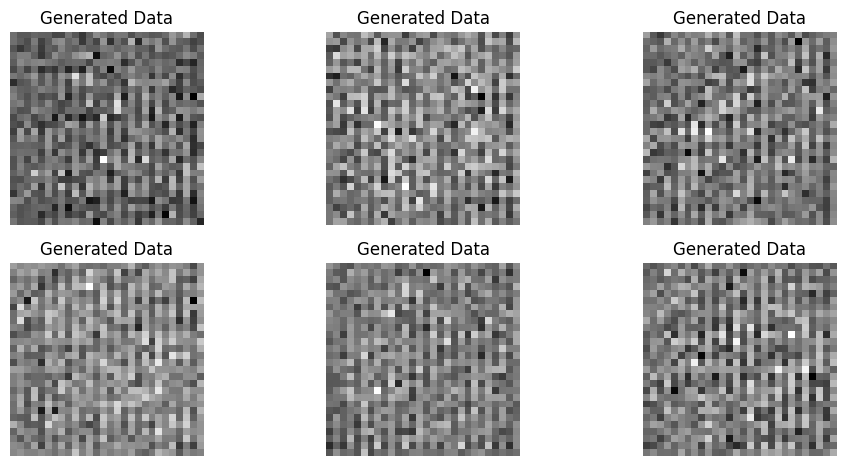

In [72]:
model.plot_images()


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

epoch 0


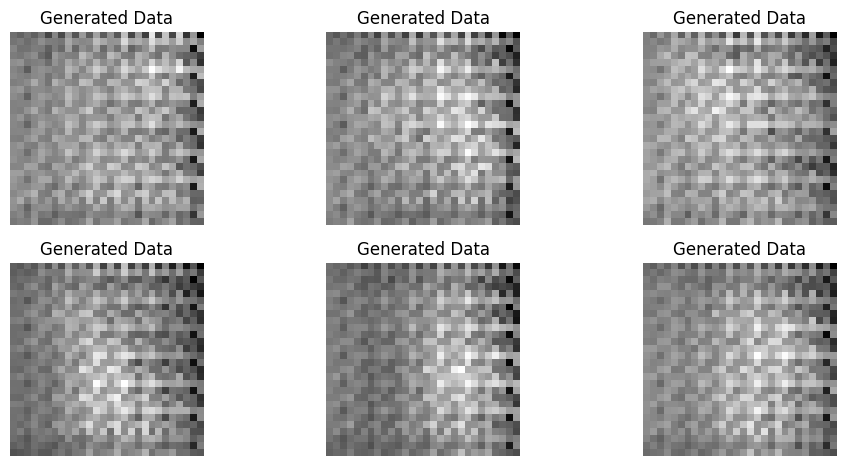

epoch 1


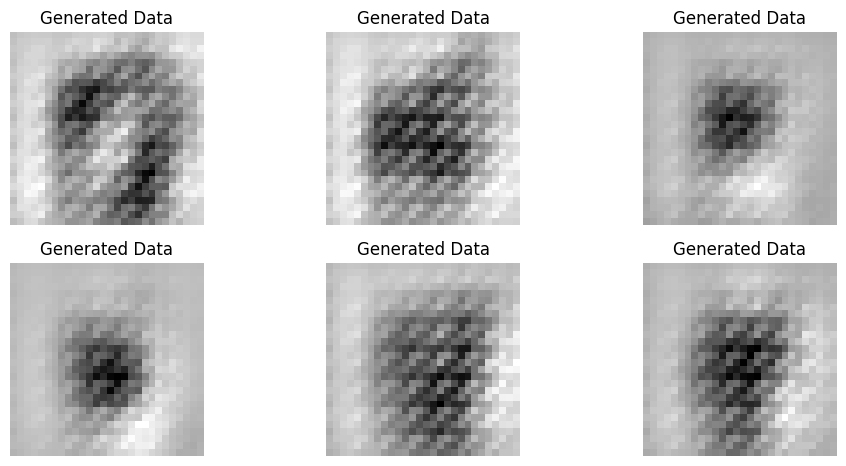

epoch 2


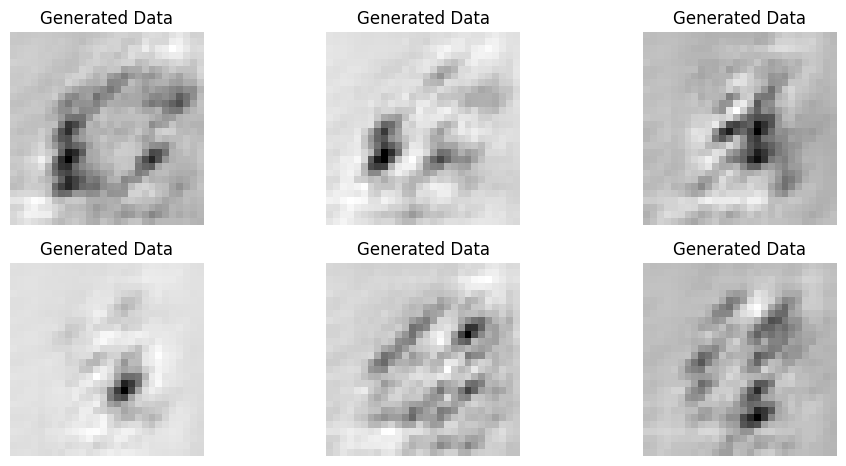

epoch 3


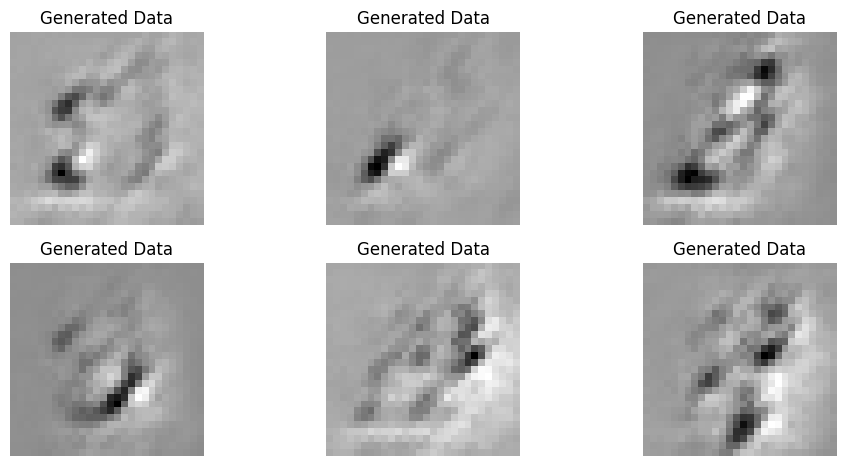

epoch 4


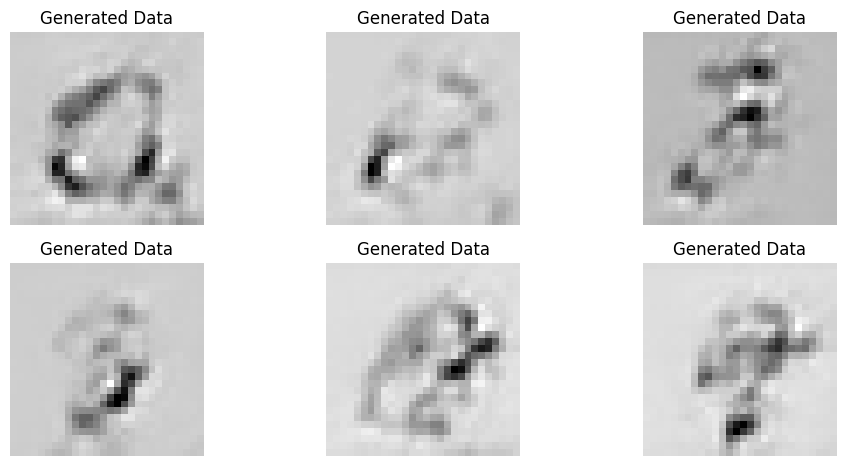

epoch 5


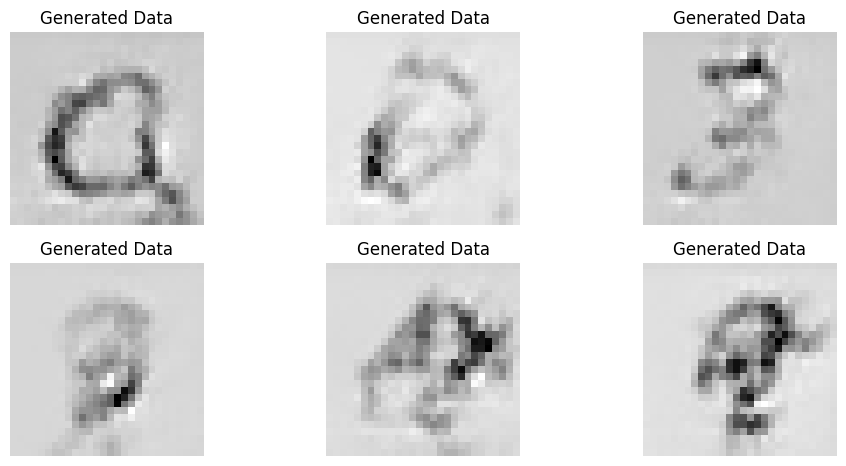

epoch 6


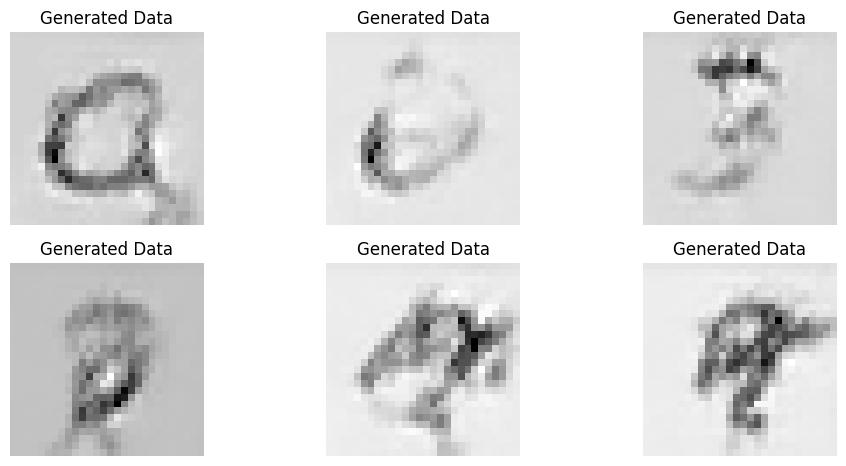

epoch 7


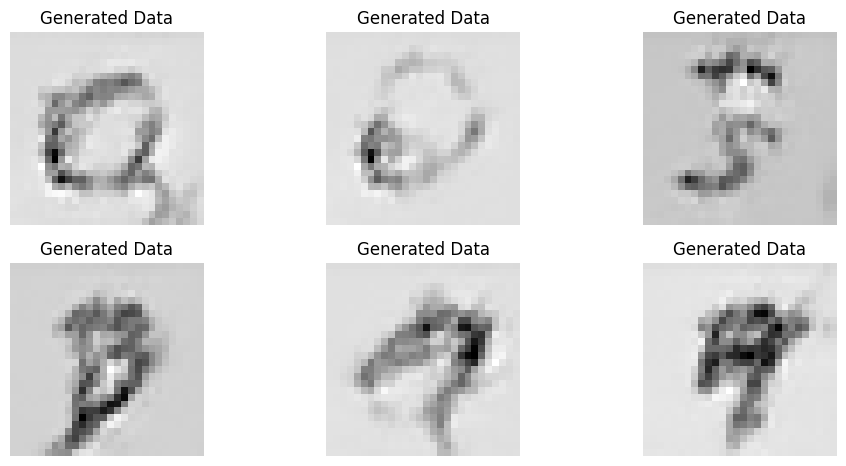

epoch 8


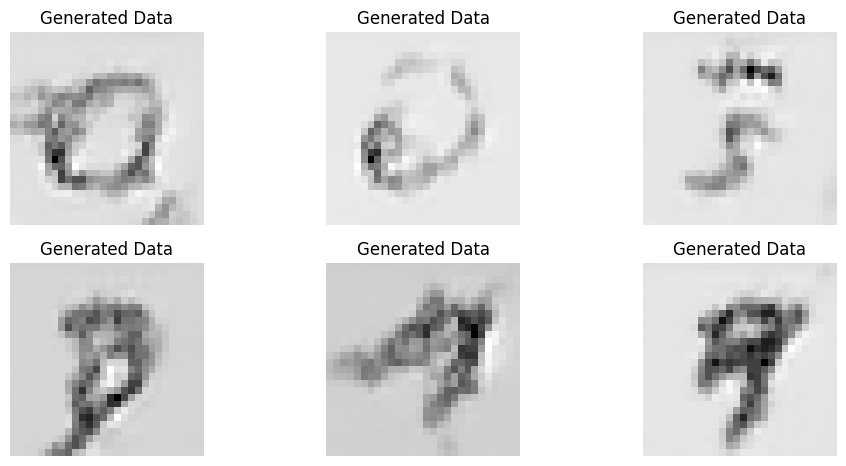

epoch 9


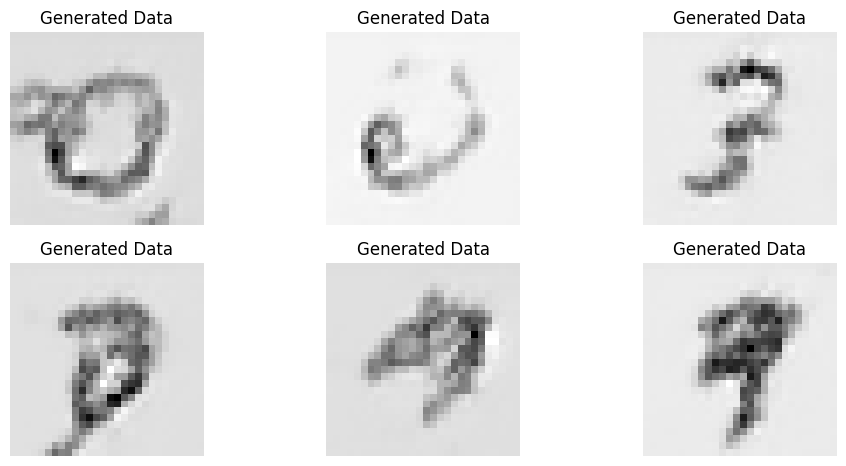

epoch 10


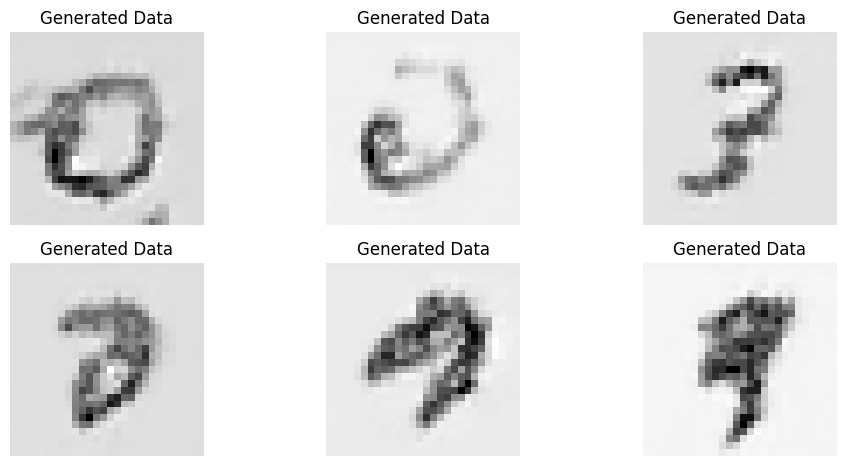

epoch 11


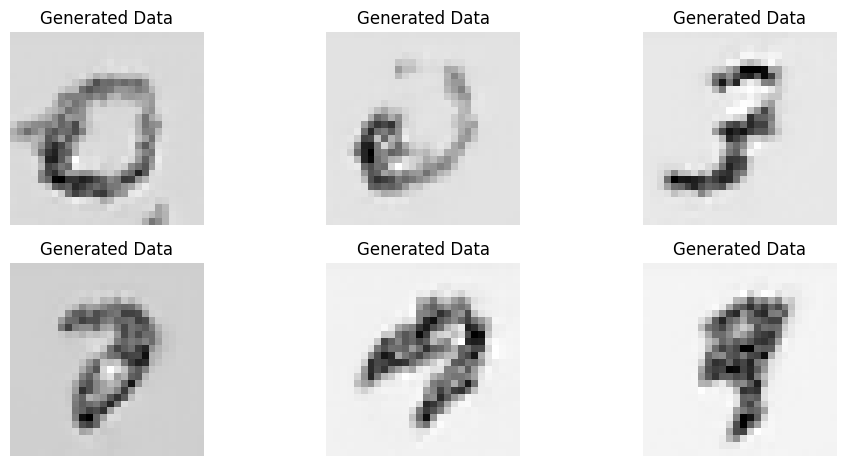

epoch 12


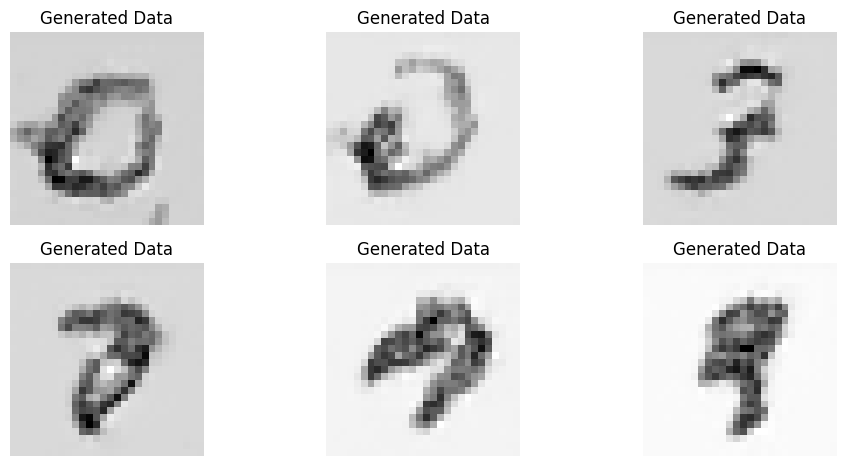

epoch 13


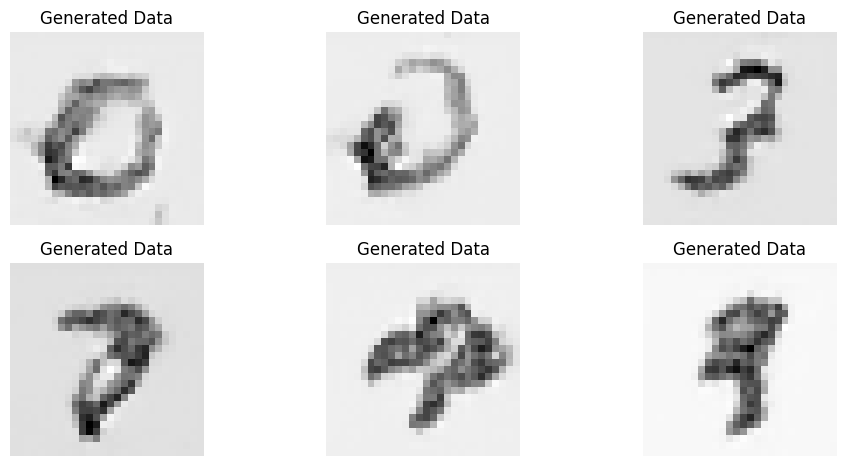

epoch 14


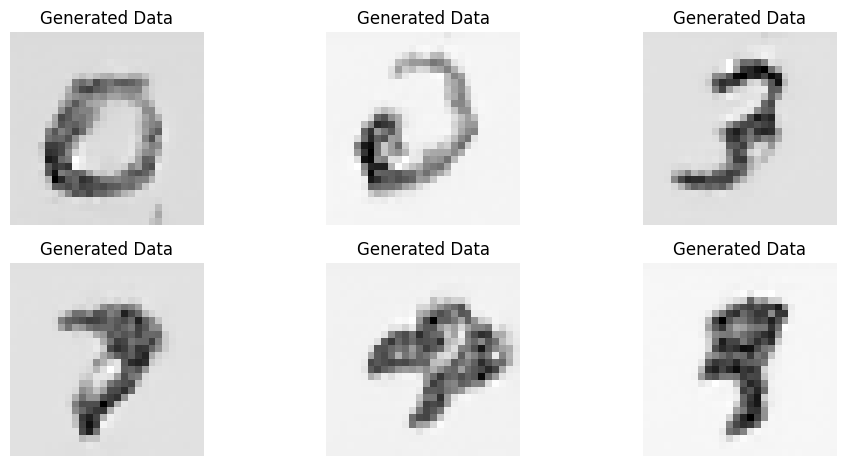

epoch 15


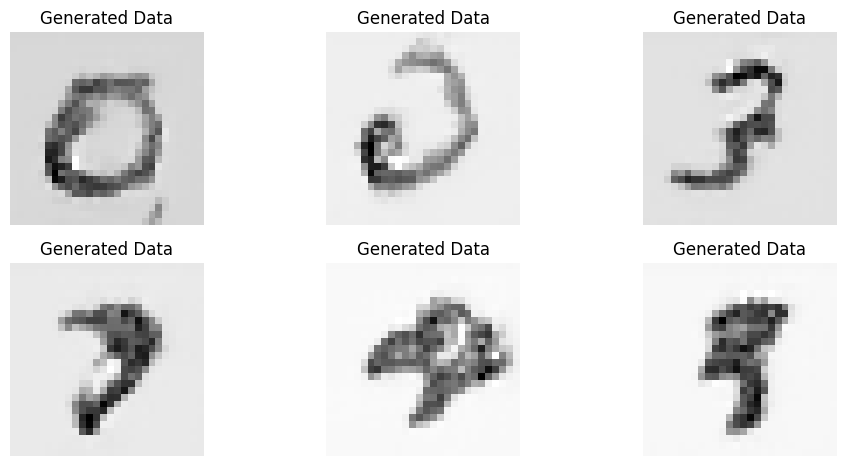

epoch 16


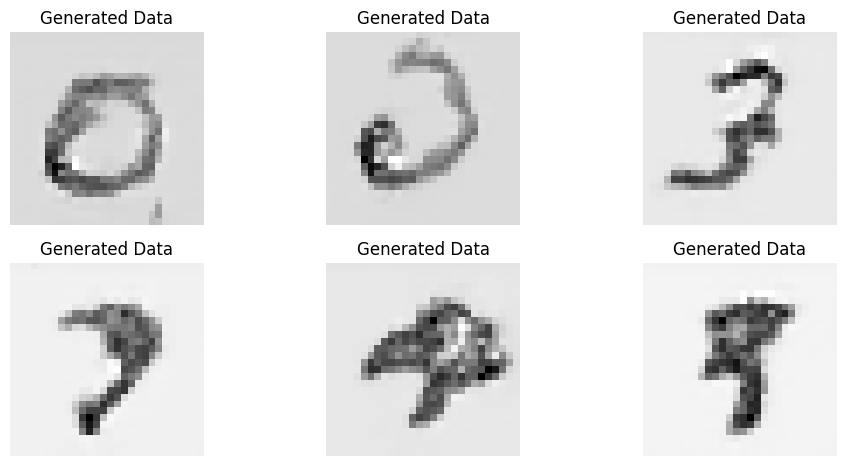

epoch 17


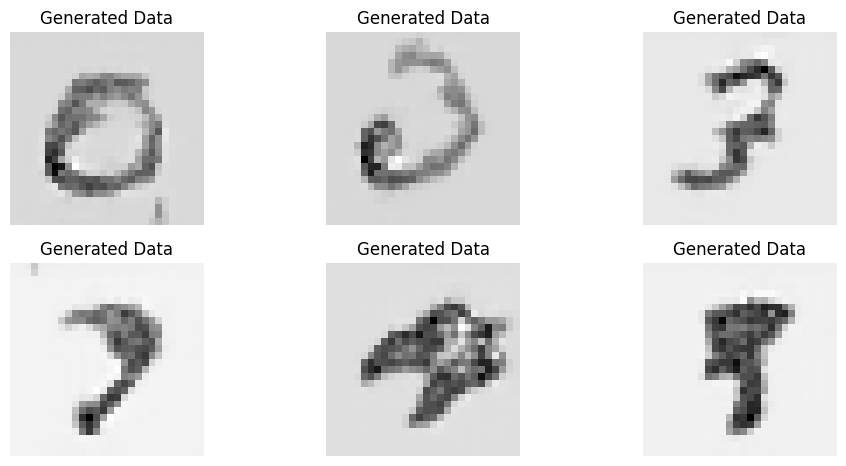

epoch 18


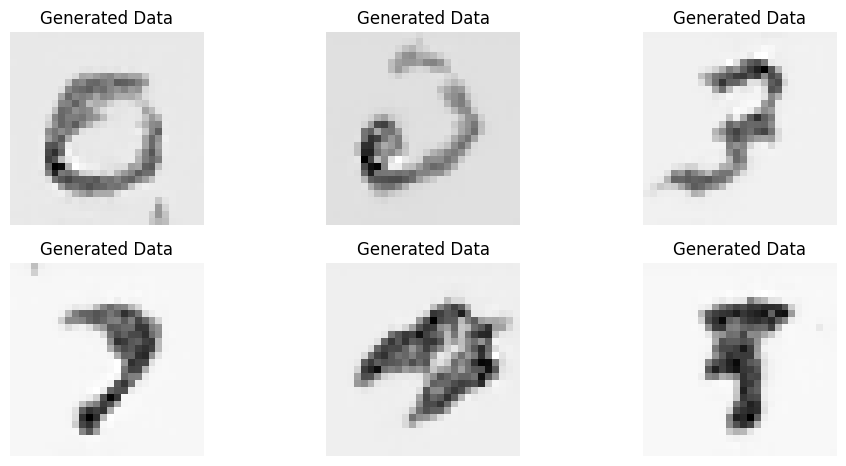

epoch 19


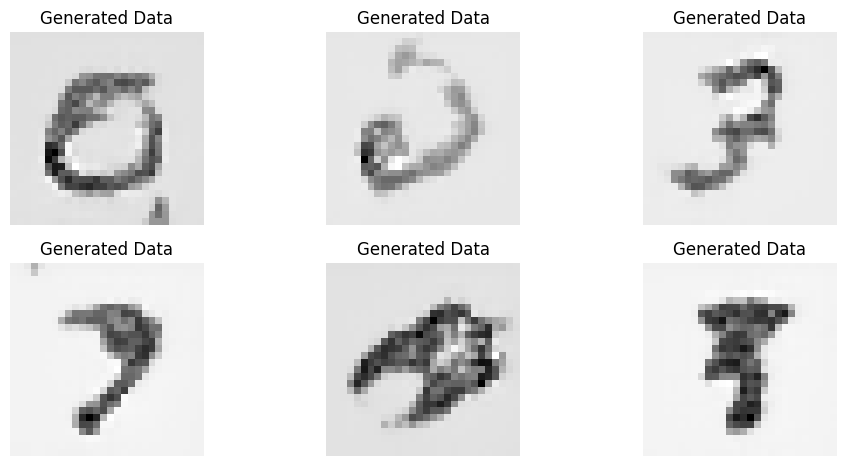

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [73]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, dm)